### Analyze Results of Hyperparameter Tuning

In [1]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import sqlite3

In [2]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("tune_hparams/tg_ppo_opt.db")

In [3]:
# List tables in the db
table_master_list_df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", con)
table_master_list_df

,name
0,studies
1,version_info
2,study_directions
3,study_user_attributes
4,study_system_attributes
5,trials
6,trial_user_attributes
7,trial_system_attributes
8,trial_params
9,trial_values


In [4]:
# Load in all the data

# There was only one study, so each of these only have one row
# studies_df = pd.read_sql_query("SELECT * FROM studies;", con)
# version_info_df = pd.read_sql_query("SELECT * FROM version_info;", con)
# study_directions_df = pd.read_sql_query("SELECT * FROM study_directions;", con)
# alembic_version_df = pd.read_sql_query("SELECT * FROM alembic_version;", con)

# Empty - tables were created but not populated
# study_user_attributes_df = pd.read_sql_query("SELECT * FROM study_user_attributes;", con)
# study_system_attributes_df = pd.read_sql_query("SELECT * FROM study_system_attributes;", con)
# trial_user_attributes_df = pd.read_sql_query("SELECT * FROM trial_user_attributes;", con)
# trial_system_attributes_df = pd.read_sql_query("SELECT * FROM trial_system_attributes;", con)
# trial_heartbeats_df = pd.read_sql_query("SELECT * FROM trial_heartbeats;", con)

# These contain the meat of the tuning results
trials_df = pd.read_sql_query("SELECT * FROM trials;", con)
trial_params_df = pd.read_sql_query("SELECT * FROM trial_params;", con)
trial_values_df = pd.read_sql_query("SELECT * FROM trial_values;", con)
trial_intermediate_values_df = pd.read_sql_query("SELECT * FROM trial_intermediate_values;", con)

### Check Hyperparameter values vs the Average Reward
Check if there are any interesting patterns with how each hyper parameter's values affected the total average reward for a trial.

In [5]:
value_param_df = trial_values_df.merge(trial_params_df, how='left', on='trial_id')
value_param_df = value_param_df[[
    'value', 
    'param_name', 
    'param_value',
    'distribution_json',
    'trial_id'
    ]]

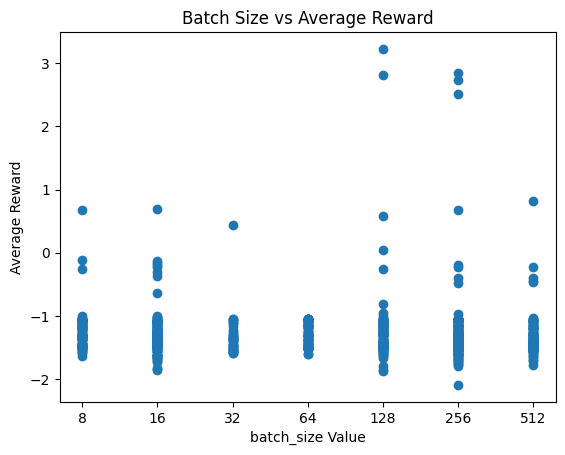

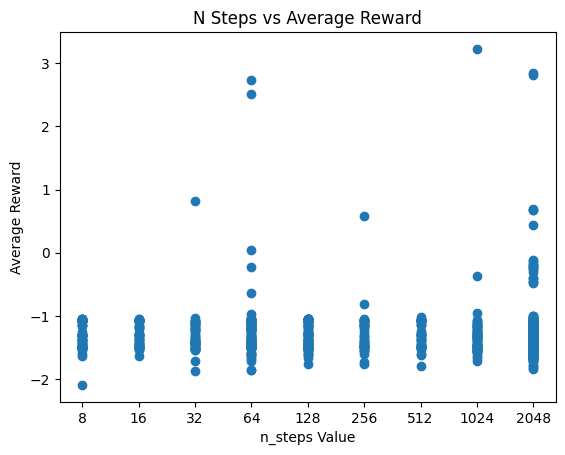

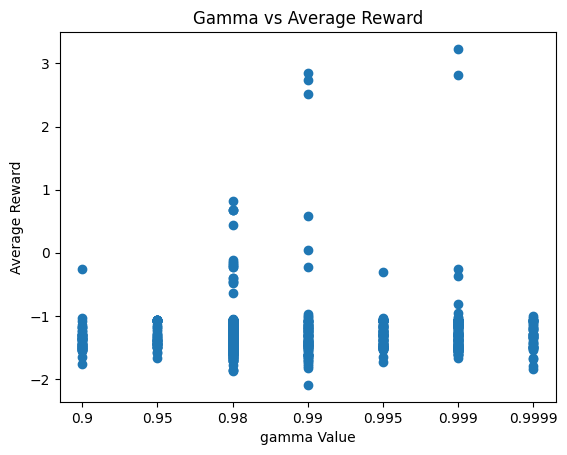

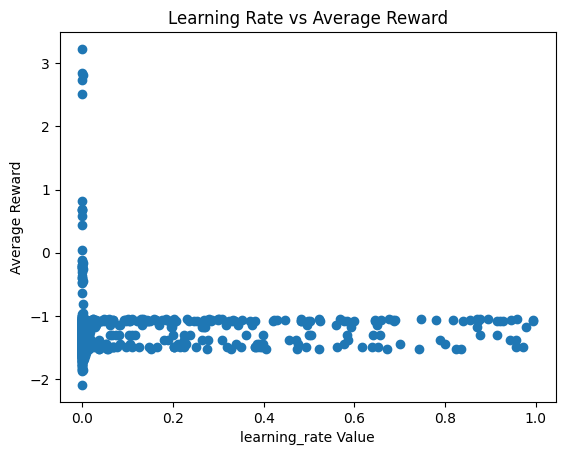

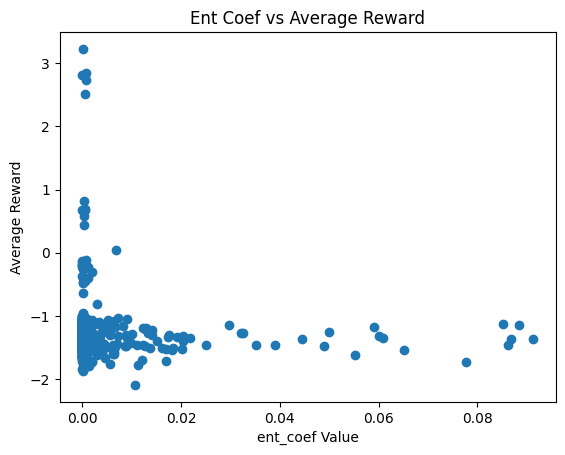

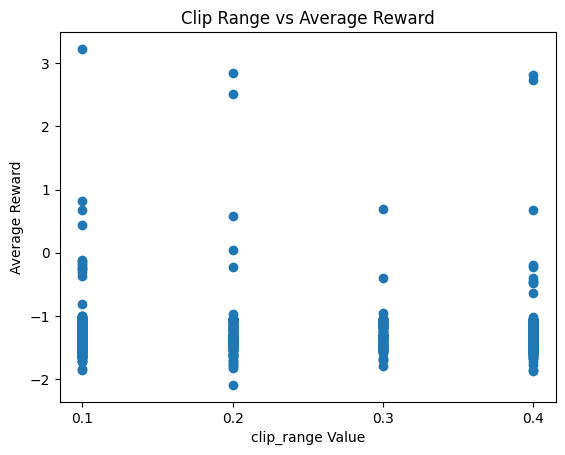

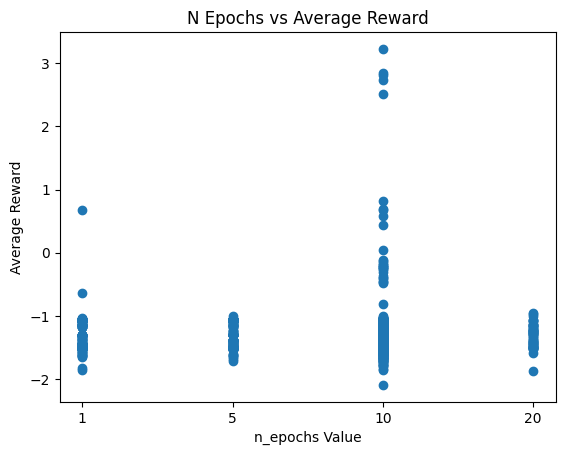

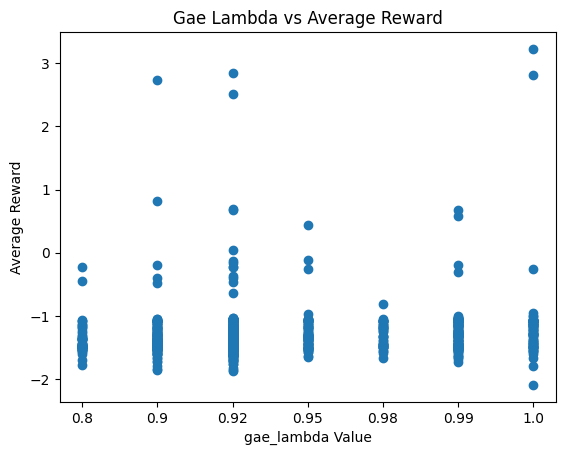

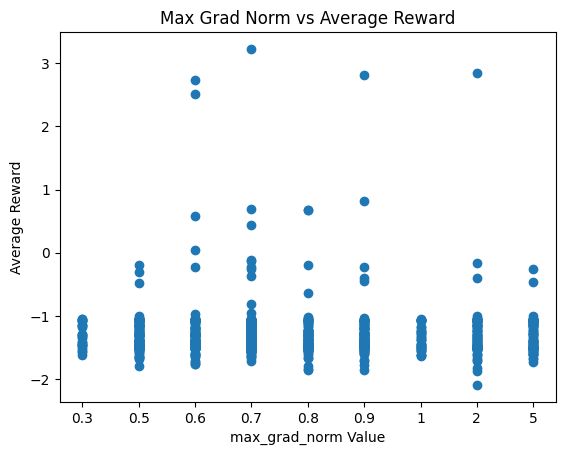

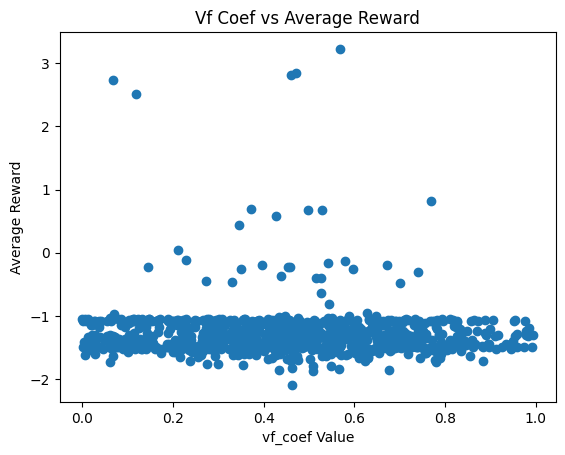

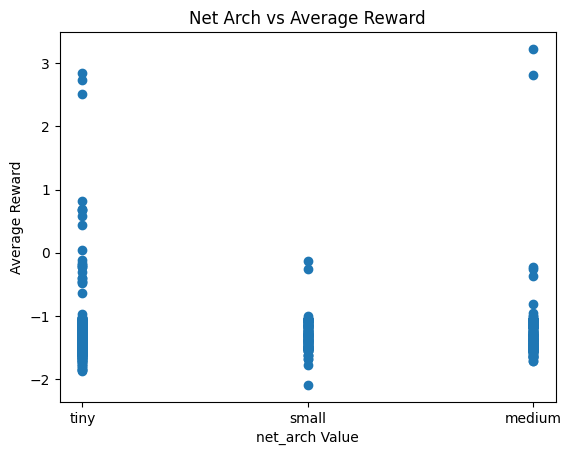

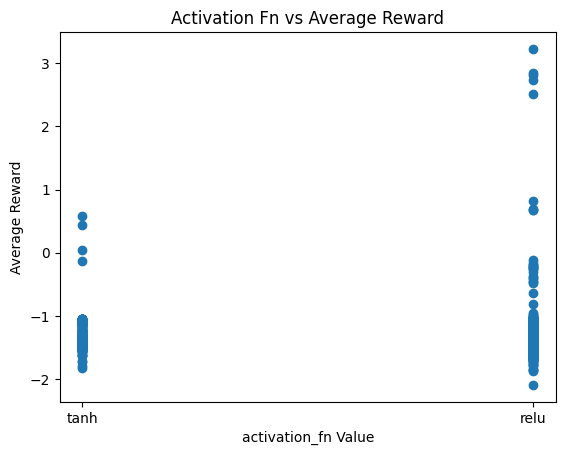

In [6]:
meta_lookup = value_param_df[['param_name', 'distribution_json']].drop_duplicates()

for param, metadata in meta_lookup.values:

    # Subset the data
    value_param_subset_df = value_param_df.loc[value_param_df['param_name']==param]

    # Get the param values for categorical parameters
    metadata = json.loads(metadata)
    tick_labels = metadata.get('attributes', {}).get('choices', None)

    param_pretty = param.replace('_', ' ').title()
    
    # Make the plot
    plt.scatter(value_param_subset_df['param_value'], value_param_subset_df['value'])
    plt.title(f'{param_pretty} vs Average Reward')
    plt.xlabel(f'{param} Value')
    plt.ylabel('Average Reward')
    if tick_labels is not None:
        # Apply tick labels for categorical params
        ticks = [i for i in range(len(tick_labels))]
        tick_labels = [str(l) for l in tick_labels]
        plt.xticks(ticks, tick_labels)

    plt.show()

### Check the parameters for the best trials
Getting to the point of tuning, lets check what the optimal parameters were

In [13]:
top_trials = trial_values_df.sort_values('value', ascending=False)['trial_id'].tolist()

In [21]:
best_trial_hparams = value_param_df.loc[value_param_df['trial_id'].isin(top_trials[0:3])].copy()
best_trial_hparams.sort_values(['value', 'param_name'], ascending=False)

,value,param_name,param_value,distribution_json,trial_id
6441,3.2308,vf_coef,0.568503,"{""name"": ""FloatDistribution"", ""attributes"": {""...",672
6442,3.2308,net_arch,2.000000,"{""name"": ""CategoricalDistribution"", ""attribute...",672
6433,3.2308,n_steps,7.000000,"{""name"": ""CategoricalDistribution"", ""attribute...",672
6438,3.2308,n_epochs,2.000000,"{""name"": ""CategoricalDistribution"", ""attribute...",672
6440,3.2308,max_grad_norm,3.000000,"{""name"": ""CategoricalDistribution"", ""attribute...",672
6435,3.2308,learning_rate,0.000285,"{""name"": ""FloatDistribution"", ""attributes"": {""...",672
6434,3.2308,gamma,5.000000,"{""name"": ""CategoricalDistribution"", ""attribute...",672
6439,3.2308,gae_lambda,6.000000,"{""name"": ""CategoricalDistribution"", ""attribute...",672
6436,3.2308,ent_coef,0.000044,"{""name"": ""FloatDistribution"", ""attributes"": {""...",672
6437,3.2308,clip_range,0.000000,"{""name"": ""CategoricalDistribution"", ""attribute...",672


In [22]:
def fix_categorical_values(row):
    metadata = metadata = json.loads(row['distribution_json'])
    if metadata['name'] == 'CategoricalDistribution':
        category_values = metadata.get('attributes', {}).get('choices', [])
        value_idx = int(row['param_value'])
        category_value = category_values[value_idx]
        return category_value
    else:
        return row['param_value']

best_trial_hparams['fixed_param_value'] = best_trial_hparams.apply(fix_categorical_values, axis=1)

In [23]:
best_trial_hparams

,value,param_name,param_value,distribution_json,trial_id,fixed_param_value
5892,2.8448,batch_size,5.000000,"{""name"": ""CategoricalDistribution"", ""attribute...",624,256
5893,2.8448,n_steps,8.000000,"{""name"": ""CategoricalDistribution"", ""attribute...",624,2048
5894,2.8448,gamma,3.000000,"{""name"": ""CategoricalDistribution"", ""attribute...",624,0.99
5895,2.8448,learning_rate,0.000067,"{""name"": ""FloatDistribution"", ""attributes"": {""...",624,0.000067
5896,2.8448,ent_coef,0.000732,"{""name"": ""FloatDistribution"", ""attributes"": {""...",624,0.000732
5897,2.8448,clip_range,1.000000,"{""name"": ""CategoricalDistribution"", ""attribute...",624,0.2
5898,2.8448,n_epochs,2.000000,"{""name"": ""CategoricalDistribution"", ""attribute...",624,10
5899,2.8448,gae_lambda,2.000000,"{""name"": ""CategoricalDistribution"", ""attribute...",624,0.92
5900,2.8448,max_grad_norm,7.000000,"{""name"": ""CategoricalDistribution"", ""attribute...",624,2
5901,2.8448,vf_coef,0.471065,"{""name"": ""FloatDistribution"", ""attributes"": {""...",624,0.471065


In [9]:
hparams = dict(best_trial_hparams[['param_name', 'fixed_param_value']].values)
for hparam, val in hparams.items():
    print(f'{hparam}: {val}')

batch_size: 128
n_steps: 1024
gamma: 0.999
learning_rate: 0.00028470451912222594
ent_coef: 4.354952186675197e-05
clip_range: 0.1
n_epochs: 10
gae_lambda: 1.0
max_grad_norm: 0.7
vf_coef: 0.5685025164996158
net_arch: medium
activation_fn: relu
